# Introduction to the xgbsurv package

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import load_metabric, load_rgbsg, load_support, load_flchain
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from xgbsurv.evaluation import cindex_censored, ibs
#from xgbsurv.models import aft_baseline_hazard_estimator
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In [2]:
data = load_metabric(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=False)
data.data.shape

(1903, 9)

## Load Data

In [3]:
data = load_metabric(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

In [4]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

## Load Model

In [20]:
early_stopping_rounds = 10
model = XGBSurv(n_estimators=50, objective="aft_objective",
                                             eval_metric="aft_loss",
                                             learning_rate=0.6,
                                             random_state=42, 
                                             disable_default_eval_metric=True,
                                             base_score=0.0,
                                             early_stopping_rounds=early_stopping_rounds,
                                             verbosity=3)

In [21]:
model.get_params

<bound method XGBModel.get_params of XGBSurv(base_score=0.0, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=True, early_stopping_rounds=10,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x2a77b4360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.6,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=50, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2a78279c0>), ...)>

The options of loss and objective functions can be obtained like below:

In [22]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [23]:
eval_set = [(X_train, y_train)]

In [24]:
np.isnan(X_train).any()

age           False
sex           False
sample_yr     False
kappa         False
lambda        False
flc_grp       False
creatinine    False
mgus          False
dtype: bool

In [25]:
validation_size = 0.2
model.fit(X_train, y_train, eval_test_size=validation_size)#eval_set=eval_set

[23:26:12] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/gbtree.cc:157: Using tree method: 2
[23:26:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-aft_likelihood:3597.84702	validation_1-aft_likelihood:902.95228
[23:26:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-aft_likelihood:3577.57373	validation_1-aft_likelihood:900.28050
[23:26:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-aft_likelihood:3554.88305	validation_

XGBSurv(base_score=0.0, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=True, early_stopping_rounds=10,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x2a77b4360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.6,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=50, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2a78279c0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [26]:
model.save_model("introduction_model_aft.json")

## Predict

In [27]:
preds_train = model.predict(X_train)#, output_margin=True
preds_test = model.predict(X_test)#, output_margin=True

In [30]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train.values, X_test.values, y_train.values, y_test.values)
df_survival_function = np.exp(-df_cum_hazards)
durations_test, events_test = transform_back(y_test.values)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 400)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
print('Brier Index',ev.integrated_brier_score(time_grid))
# 0.53, 0.17

Concordance Index 0.7881180303829478
Brier Index 0.09479217826393188


In [14]:
cindex_censored(y_train, preds_train)

0.6982670118269267

In [15]:
cindex_censored(y_test, preds_test)

0.5874987466158629

### Predict Cumulative Hazard

In [16]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards #.T

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
0.100000,7.326896e-32,7.326896e-32,3.001037e-39,3.001037e-39,3.001037e-39,7.326896e-32,1.056258e-21,3.001037e-39,7.326896e-32,7.326896e-32,...,3.001037e-39,3.001037e-39,3.001037e-39,3.001037e-39,3.001037e-39,3.001037e-39,3.001037e-39,3.001037e-39,7.326896e-32,7.326896e-32
1.266667,5.586683e-06,1.935107e-05,5.293051e-07,3.642129e-07,5.293051e-07,1.935107e-05,4.724173e-04,1.051960e-06,2.729745e-05,5.586683e-06,...,2.586294e-06,2.586294e-06,5.293051e-07,5.293051e-07,3.642129e-07,2.586294e-06,2.450289e-07,5.293051e-07,5.586683e-06,1.935107e-05
1.433333,1.610125e-05,4.999642e-05,1.946682e-06,1.442901e-06,1.946682e-06,4.999642e-05,7.705703e-04,4.377318e-06,6.528464e-05,1.610125e-05,...,8.793373e-06,8.793373e-06,1.946682e-06,1.946682e-06,1.442901e-06,8.793373e-06,1.051960e-06,1.946682e-06,1.610125e-05,4.999642e-05
2.400000,4.460106e-04,7.705703e-04,1.429715e-04,1.167197e-04,1.429715e-04,8.033384e-04,3.069487e-03,2.234283e-04,9.043053e-04,4.460106e-04,...,3.029579e-04,3.029579e-04,1.429715e-04,1.429715e-04,1.167197e-04,3.029579e-04,9.377334e-05,1.429715e-04,4.460106e-04,8.033384e-04
6.266667,5.130998e-03,6.178629e-03,3.629097e-03,3.391191e-03,3.629097e-03,6.215392e-03,1.512949e-02,4.094661e-03,6.550739e-03,5.058694e-03,...,4.546286e-03,4.546286e-03,3.629097e-03,3.629097e-03,3.391191e-03,4.546286e-03,3.230913e-03,3.629097e-03,5.058694e-03,6.215392e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292.033325,1.600032e+00,1.853863e+00,1.234645e+00,1.181928e+00,1.234645e+00,1.868258e+00,3.171539e+00,1.348985e+00,1.944161e+00,1.579409e+00,...,1.451237e+00,1.451237e+00,1.234645e+00,1.234645e+00,1.181928e+00,1.451237e+00,1.148628e+00,1.234645e+00,1.579409e+00,1.864612e+00
296.866669,1.629904e+00,1.887634e+00,1.258254e+00,1.204536e+00,1.258254e+00,1.902398e+00,3.222001e+00,1.374774e+00,1.979555e+00,1.608898e+00,...,1.478601e+00,1.478601e+00,1.258254e+00,1.258254e+00,1.204536e+00,1.478601e+00,1.171014e+00,1.258254e+00,1.608898e+00,1.898564e+00
330.366669,1.836582e+00,2.121570e+00,1.422917e+00,1.363033e+00,1.422917e+00,2.137714e+00,3.561982e+00,1.552809e+00,2.222568e+00,1.813144e+00,...,1.668438e+00,1.668438e+00,1.422917e+00,1.422917e+00,1.363033e+00,1.668438e+00,1.325323e+00,1.422917e+00,1.813144e+00,2.133537e+00
335.733337,1.869601e+00,2.158775e+00,1.449310e+00,1.388444e+00,1.449310e+00,2.175265e+00,3.614705e+00,1.581336e+00,2.261257e+00,1.845800e+00,...,1.698869e+00,1.698869e+00,1.449310e+00,1.449310e+00,1.388444e+00,1.698869e+00,1.350139e+00,1.449310e+00,1.845800e+00,2.171097e+00


In [17]:
# np.savetxt('debug_files/X_train.csv', X_train, delimiter=',')
# np.savetxt('debug_files/X_test.csv', X_test, delimiter=',')
# #np.savetxt('/debug_files/y_train.csv', y_train, delimiter=',')
# np.savetxt('debug_files/y_test.csv', y_test, delimiter=',')

# time_test, event_test = transform_back(y_test)
# np.savetxt('debug_files/time.csv', np.unique(time_test), delimiter=',')
# time_train, event_train = transform_back(y_train)
# np.savetxt('debug_files/time_train.csv', time_train, delimiter=',')
# np.savetxt('debug_files/event_train.csv', event_train, delimiter=',')
# np.savetxt('debug_files/predictor_train.csv', preds_train, delimiter=',')
# np.savetxt('debug_files/predictor_test.csv', preds_test, delimiter=',')

In [18]:
df_survival_function = np.exp(-df_cum_hazards)


In [19]:
df_survival_function.to_csv('aft_sample_surv.csv')

Text(0.5, 1.0, 'Survival Curve Test Set')

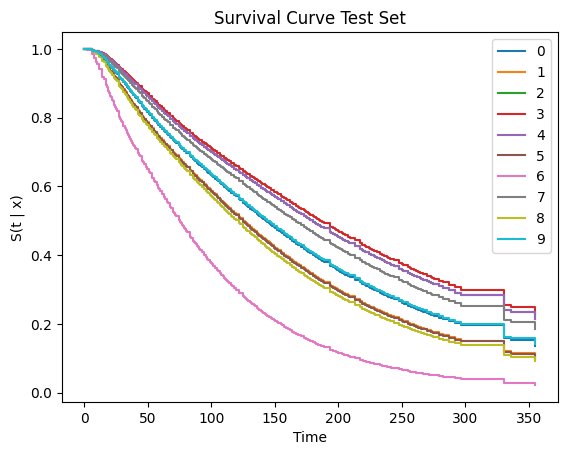

In [20]:

df_survival_function.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

In [2]:
from xgbsurv.datasets import (load_metabric, load_flchain, load_rgbsg, load_support, load_tcga)
from xgbsurv import XGBSurv
from xgbsurv.evaluation import cindex_censored, ibs
from xgbsurv.models.utils import sort_X_y
import os
import numpy as np
import pandas as pd
from scipy.stats import uniform as scuniform
from scipy.stats import randint as scrandint
from scipy.stats import loguniform as scloguniform 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
# import models
from xgbsurv.models.eh_aft_final import aft_likelihood, get_cumulative_hazard_function_aft
from pycox.evaluation import EvalSurv
from xgbsurv.models.utils import sort_X_y_pandas, transform_back, transform
from xgbsurv.preprocessing.dataset_preprocessing import discretizer_df
from sklearn.utils.fixes import loguniform
np.random.seed(42)

In [11]:
param_grid = {
#'estimator__reg_alpha': scloguniform(1e-10,1),#[1e-10,1], # from hyp augmentation, L1 regularization
'estimator__reg_lambda': scloguniform(1e-10,1), #[1e-10,1], #alias l2_regularization, lambda in augmentation
'estimator__learning_rate': scloguniform(0.01,1.0), #[0.001,1], # assumed alias eta from augmentation,
'estimator__n_estimators':  scrandint(1,150),#00), # corresponds to num_rounds
#'estimator__gamma': [0],#loguniform(0.001,1-0.5),#[0.1,1], # minimum loss reduction required to make a further partition on a leaf node of the tree.
'estimator__colsample_bylevel': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation
'estimator__colsample_bynode': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation, uniform(0.1,1),
'estimator__colsample_bytree': scuniform(0.5, 1-0.5),#[0.5,1], # from hyp augmentation, seems to exceed the bound, uniform(0.5,1)
'estimator__max_depth': scrandint(1,20),#[1,20], # from hyp augmentation
'estimator__max_delta_step': scrandint(0,10),#[0,10], # from hyp augmentation
'estimator__min_child_weight' : scloguniform(0.1,20-0.1),#[0.1,20], # from hyp augmentation
'estimator__subsample': scuniform(0.01,1-0.01),#[0.01,1], # from hyp augmentation
}
n_outer_splits = 5
n_inner_splits = 5
rand_state = 42
n_iter = 1 #50 #0
early_stopping_rounds=10
base_score = 0.0
validation_size = 0.2

In [12]:
#scoring_function = make_scorer(aft_likelihood, greater_is_better=False) #changed here
def custom_scoring_function(y_true, y_pred):

        if not isinstance(y_true, np.ndarray):
            y_true = y_true.values
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values
        # change order of this later
        score = -aft_likelihood(y_true, y_pred)
        return score

scoring_function = make_scorer(custom_scoring_function, greater_is_better=False)

In [13]:
class CustomSplit(StratifiedKFold):
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        try:
            if y.shape[1]>1:
                y = y[:,0]
        except:
            pass
        bins = np.sign(y)
        return super().split(X, bins, groups=groups)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

outer_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)
inner_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)

In [14]:
ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=['float32'])),
        (OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['category', 'object'])),
        remainder='passthrough')

estimator = XGBSurv(
    objective='aft_objective',
    eval_metric='aft_loss',
    random_state=rand_state, 
    disable_default_eval_metric=True,
    early_stopping_rounds=early_stopping_rounds, 
    base_score=base_score,
                    )
pipe = Pipeline([('scaler',ct),
                ('estimator', estimator)])
    
rs = RandomizedSearchCV(pipe, param_grid, scoring = scoring_function, n_jobs=-1, 
                             cv=inner_custom_cv, n_iter=2, refit=True, 
                             random_state=rand_state, verbose=10,
                             error_score = 'raise')
data = load_flchain(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=True)
filename = data.filename
X  = data.data #.astype(np.float32)
y = data.target #.values #.to_numpy()

for i, (train_index, test_index) in enumerate(outer_custom_cv.split(X, y)):
        # Split data into training and testing sets for outer fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, y_train = sort_X_y_pandas(X_train, y_train)
        X_test, y_test = sort_X_y_pandas(X_test, y_test)
        rs.fit(X_train, y_train, estimator__eval_test_size=validation_size)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 5/5; 1/2] START estimator__colsample_bylevel=0.4370861069626263, estimator__colsample_bynode=0.9556428757689246, estimator__colsample_bytree=0.8659969709057025, estimator__learning_rate=0.15751320499779722, estimator__max_delta_step=6, estimator__max_depth=19, estimator__min_child_weight=0.16975698090861446, estimator__n_estimators=88, estimator__reg_lambda=2.173132022165888e-07, estimator__subsample=0.15143814974272138
[CV 1/5; 2/2] START estimator__colsample_bylevel=0.6857996256539676, estimator__colsample_bynode=0.15077042112439024, estimator__colsample_bytree=0.8609993861334124, estimator__learning_rate=0.7535384509295543, estimator__max_delta_step=1, estimator__max_depth=1, estimator__min_child_weight=0.5005047646703362, estimator__n_estimators=22, estimator__reg_lambda=1.1766926810981162e-10, estimator__subsample=0.0328318007910016
[CV 3/5; 2/2] START estimator__colsample_bylevel=0.6857996256539676, estimator__colsam

In [15]:
best_preds_train = rs.best_estimator_.predict(X_train)
best_preds_test = rs.best_estimator_.predict(X_test)
print('best_preds_train',best_preds_train)
print('best_preds_test',best_preds_test)
print(best_preds_train.shape)
print(best_preds_test.shape)

best_preds_train [-0.32159922 -0.24294059 -0.26499164 ... -0.35212642 -0.4584922
  0.3894835 ]
best_preds_test [ 1.3358037   0.62585944  0.5661921  ... -0.29968822 -0.34906667
 -0.39078358]
(6297,)
(1574,)


In [16]:
# cum_hazard_train = get_cumulative_hazard_function_aft(
#         X_train.values, X_test.values, y_train.values, y_test.values,
#         best_preds_train.reshape(-1), best_preds_train.reshape(-1)
#         )

# df_survival_train = np.exp(-cum_hazard_train)
# durations_train, events_train = transform_back(y_train.values)
# time_grid_train = np.linspace(durations_train.min(), durations_train.max(), 100)
# ev = EvalSurv(df_survival_train, durations_train, events_train, censor_surv='km')
# print('Concordance Index',ev.concordance_td('antolini'))
# print('Integrated Brier Score:',ev.integrated_brier_score(time_grid_train))

In [17]:
cum_hazard_test = get_cumulative_hazard_function_aft(
        X_train.values, X_test.values, y_train.values, y_test.values,
        best_preds_train.reshape(-1), best_preds_test.reshape(-1)
        )

df_survival_test = np.exp(-cum_hazard_test)
durations_test, events_test = transform_back(y_test.values)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_test, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
#flchain without onehot encoding: 0.7877551707497727, n_iter=2: ,0.767814724619465 with loss function sign changed
#flchain with onehot encoding:


Concordance Index 0.7465724727948796


In [11]:
data = load_flchain(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=True)

age           float32
sex             uint8
sample_yr     float32
kappa         float32
lambda        float32
flc_grp       float32
creatinine    float32
mgus            uint8
dtype: object

## Predict Survival Function

In [ ]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
318.200012,0.241719,0.226924,0.203765,0.191910,0.236460,0.226924,0.206582,0.223351,0.236288,0.206318,...,0.236460,0.219993,0.217993,0.223718,0.235301,0.228127,0.235301,0.217317,0.234916,0.214751
335.600006,0.221201,0.206847,0.184586,0.173280,0.216089,0.206847,0.187317,0.203429,0.215931,0.187043,...,0.216089,0.200176,0.198278,0.203765,0.214986,0.208062,0.214986,0.197625,0.214594,0.195140
351.000000,0.204438,0.190542,0.169125,0.158284,0.199481,0.190542,0.171726,0.187249,0.199334,0.171473,...,0.199481,0.184112,0.182262,0.187593,0.198387,0.191699,0.198387,0.181627,0.198060,0.179273


### Visualize Predictions

Text(0.5, 1.0, 'Survival Curve Test Set')

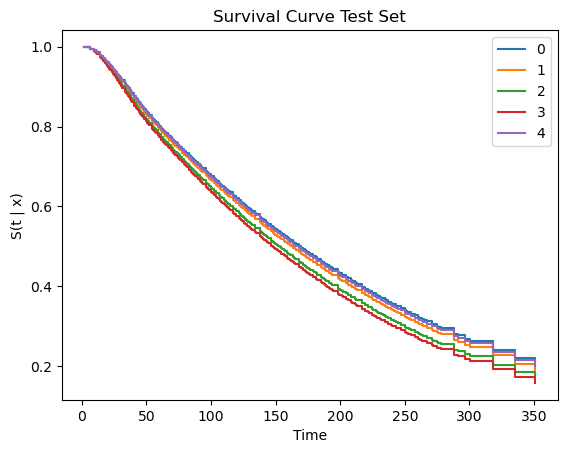

In [ ]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

## Evaluate

In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6070646458397773


In [ ]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18551198595050641
